Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Uvod u znanost o podacima 2023/2024 
https://www.fer.unizg.hr/predmet/uuzop

------------------------------

## Projekt: Early-Stage Alzheimer's Disease Prediction Using Machine Learning Models

*https://www.frontiersin.org/articles/10.3389/fpubh.2022.853294/full*

**Mia Bošnjak,  0036526611  
Petra Petrović, 0036526611  
Veronika Žunar, 0036525058**  

------------------------------

In [1]:
#Import blok
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
)

# Priprema i vizualizacija podataka

#### Učitavanje podataka

In [2]:
df = pd.read_csv(".\dataset\oasis_longitudinal.csv")
df

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


#### Opisi i tipovi podataka

In [3]:
data = df.copy()

cols = data.columns
desc = ["Subject Identification", "MRI Identification", "Group of patient (classification)", "Ordinal number of visit","MR delay", "Gender (M if Male, F if Female)", "Handedness", "Age in years", "Years of education", "Socio Economic Status", "Mini Mental State Examination", "Clinical Dementia Rating", "Estimated Total Intracranial Volume", "Normalize Whole Brain Volume", "Atlas Scaling Factor"]
types = data.dtypes

for col, d, typ in zip(cols, desc, types):
    print(f'\033[1m{col}\033[0m - {d} \033[1m[{typ}]\033[0m')

print()
m, n = data.shape
print(f'\033[1mBroj stupaca dataseta: {n}\033[0m')
print(f'\033[1mBroj redaka dataseta: {m}\033[0m')

Subject ID - Subject Identification [object]
MRI ID - MRI Identification [object]
Group - Group of patient (classification) [object]
Visit - Ordinal number of visit [int64]
MR Delay - MR delay [int64]
M/F - Gender (M if Male, F if Female) [object]
Hand - Handedness [object]
Age - Age in years [int64]
EDUC - Years of education [int64]
SES - Socio Economic Status [float64]
MMSE - Mini Mental State Examination [float64]
CDR - Clinical Dementia Rating [float64]
eTIV - Estimated Total Intracranial Volume [int64]
nWBV - Normalize Whole Brain Volume [float64]
ASF - Atlas Scaling Factor [float64]

Broj stupaca dataseta: 15
Broj redaka dataseta: 373


#### Pretvorba ne-numeričkih značajki u numeričke

In [4]:
le = LabelEncoder()
le.fit(data.loc[:,'Subject ID'])
data.loc[:,'Subject ID'] = le.transform(data.loc[:,'Subject ID'])

le.fit(data.loc[:,'MRI ID'])
data.loc[:,'MRI ID'] = le.transform(data.loc[:,'MRI ID'])

handedness0 = df['Hand'].unique()
data['Hand'] = df['Hand'].map({'L': 0, 'R': 1})
handedness = data['Hand'].unique()
print(f'Jača ruka ispitanika: {handedness0} što odgovara oznakama {handedness}')

sex0 = df['M/F'].unique()
data['M/F'] = df['M/F'].map({'M': 0, 'F': 1})
sex = data['M/F'].unique()
print(f'Spol ispitanika: {sex0} što odgovara oznakama {sex}')

groups0 = df['Group'].unique()
data['Group'] = df['Group'].map({'Nondemented': 0, 'Demented': 1, 'Converted': 2})
groups = data['Group'].unique()
print(f'Rezultati podijeljeni u *{len(groups)}* grupe: {groups0} što odgovara oznakama {groups}')

Jača ruka ispitanika: ['R'] što odgovara oznakama [1]
Spol ispitanika: ['M' 'F'] što odgovara oznakama [0 1]
Rezultati podijeljeni u *3* grupe: ['Nondemented' 'Demented' 'Converted'] što odgovara oznakama [0 1 2]


#### Nedostajuće vrijednosti

Za slučaj SES značajki uzet ćemo median vrijednost umjesto nedostajućih jer su podaci numerički.  
Dok će za značajku MMSE nedostajuće vrijednosti biti izbačene jer ih nema mnogo.

In [5]:
data.loc[df['SES'].isna(), 'SES'] = df.loc[:, 'SES'].median()
data = data.loc[df['MMSE'].notnull(), :]

# Replikacija rezultata

#### Rezultati članka

| Model     | Acurracy | Precision    | Recall   | F1-score |
|-----------|-------------------|--------|---------|----------|
| Decision tree classifier     |      80.46%             |   0.80     |    0.79     |     0.78     |
| Random forest classifier     |         86.92%          |     0.85   |    0.81     |     0.80     |
| Support vector machine     |        81.67%           |    0.77    |    0.70     |    0.79      |
| XGBoost     |         85.92%          |    0.85    |     0.83    |     0.85     | 
| Voting classifier     |      85.12%             |     0.83   |    0.83     |     0.85     |

#### Mia Bošnjak

| Model                      | Accuracy | Precision | Recall | F1-score |
|-----------------------------|----------|-----------|--------|----------|
| Decision Tree Classifier   | 75.00%    | 0.7787    | 0.7652 | 0.7719   |
| Random Forest Classifier   | 78.50%   |  0.7850    | 0.8 | 0.7850   |
| SVM Classifier             | 77.36%  | 0.7736    | 0.7736 | 0.7736   |
| XGBoost Classifier         | 80.35%   | 0.8036    | 0.8036 | 0.8035   |
| Voting Classifier           | 78.90%   | 0.8038    | 0.8108 | 0.7778   |



#### Petra Petrović

| Model                      | Accuracy | Precision | Recall | F1-score |
|-----------------------------|----------|-----------|--------|----------|
| Decision Tree Classifier   | 76.67%   | 0.7667    | 0.7667  | 0.7667   |
| Random Forest Classifier   | 80.00%   | 0.8    | 0.8 | 0.8000   |
| SVM Classifier             | 86.66%   | 0.8667    | 0.8667 | 0.8667   |
| XGBoost Classifier         | 76.67%   | 0.7667    | 0.7667 | 0.7667   |
| Voting Classifier           | 80.00%   | 0.8667    | 0.8667 | 0.8667   |



#### Veronika Žunar

| Model                      | Accuracy | Precision | Recall | F1-score |
|-----------------------------|----------|-----------|--------|----------|
| Decision Tree Classifier   | 56.67%   | 0.6571    | 0.5667 | 0.5535   |
| Random Forest Classifier   | 73.33%   | 0.7643    | 0.7333 | 0.7357   |
| SVM Classifier             | 73.33%   | 0.7446    | 0.7333 | 0.7357   |
| XGBoost Classifier         | 66.67%   | 0.6964    | 0.6667 | 0.6696   |
| Voting Classifier           | 60.00%   | 0.6500    | 0.6000 | 0.6000   |


# Poboljšanje rezultata

In [6]:
data = data.groupby('Subject ID').first().reset_index()

In [7]:
#NOVE ZNAČAJKE
data['eTIV_nWBV_Ratio'] = data['eTIV'] / data['nWBV']
data['Education_MMSE'] = data['EDUC'] * data['MMSE']
data['BrainVolume_Education_Ratio'] = data['eTIV'] / data['EDUC']
data['EDUC_nWBV'] = data['EDUC'] / data['nWBV']

In [8]:
data['CDR'] = data['CDR'].replace({0.5: 1})

#### Odabir i podjela podataka

In [9]:
selected_features = ['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF','eTIV_nWBV_Ratio']

X = data[selected_features]  # Odabir značajki za X
y = data['CDR'] # Varijabla koju želim predviđati

In [10]:
X

,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,eTIV_nWBV_Ratio
0,0,87,14,2.0,27.0,1987,0.696,0.883,2854.885057
1,0,75,12,2.0,23.0,1678,0.736,1.046,2279.891304
2,1,88,18,3.0,28.0,1215,0.710,1.444,1711.267606
3,0,80,12,4.0,28.0,1689,0.712,1.039,2372.191011
4,0,71,16,2.0,28.0,1357,0.748,1.293,1814.171123
...,...,...,...,...,...,...,...,...,...
145,0,73,12,2.0,23.0,1661,0.698,1.056,2379.656160
146,1,66,13,2.0,30.0,1495,0.746,1.174,2004.021448
147,1,72,16,3.0,24.0,1354,0.733,1.296,1847.203274
148,0,80,16,1.0,28.0,1704,0.711,1.030,2396.624473


In [11]:
y

0      0.0
1      1.0
2      0.0
3      0.0
4      1.0
      ... 
145    1.0
146    0.0
147    1.0
148    1.0
149    0.0
Name: CDR, Length: 150, dtype: float64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

#### Evaluacija modela

In [13]:
metrics={}

In [14]:
def evaluate(model, model_name):
    
    y_pred=model.predict(X_test)
    
    acc_score = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred) #, average='weighted', zero_division=1
    recall = recall_score(y_test, y_pred) #, average='weighted', zero_division=1
    f1_s = f1_score(y_test, y_pred) #, average='weighted', zero_division=1
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    metrics[model_name] = {"Accuracy": acc_score,
                           "Precision": precision,
                           "Recall": recall,
                           "F1-score": f1_s}
    
    print(f"Accuracy: {acc_score*100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1_s:.2f}")
    
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # ROC Curve for binary classification
    if len(set(y_test)) == 2:
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot()
        plt.show()

## Decision tree classifier

In [17]:
def train_decision_tree(X_train, X_test, y_train, y_test, max_depth=None, num_folds=10):
    
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle= True, random_state= 42)
    params = {'max_depth': np.arange(2, 11),
            'min_samples_leaf': np.arange(2, 11)}
    
    best_tree = GridSearchCV(estimator=model, param_grid=params, cv=skf, n_jobs= -1)
    best_tree.fit(X_train, y_train)
    print(f'Best depth: {best_tree.best_params_["max_depth"]}')
    print(f'Min samples leaf: {best_tree.best_params_["min_samples_leaf"]}\n')
    
    # Cross-validation
    cv_results = cross_val_score(best_tree, X_train, y_train, cv=skf, scoring='accuracy')
    print(f'Cross-Validation Accuracy (Decision Tree): {np.mean(cv_results)}')
    
    evaluate(best_tree, "Decision tree classifier")

Best depth: 4
Min samples leaf: 5

Cross-Validation Accuracy (Decision Tree): 0.8333333333333333
Accuracy: 86.67%
Precision: 0.67
Recall: 1.00
F1 score: 0.80


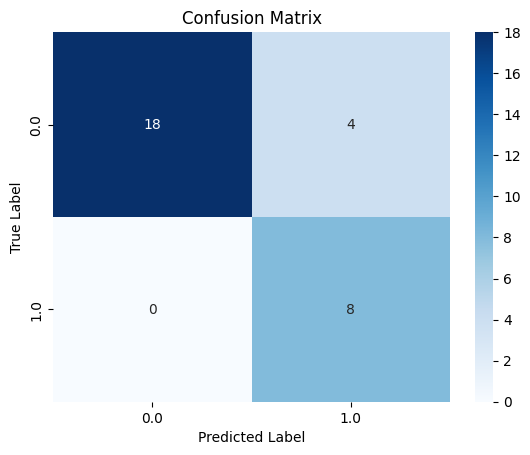

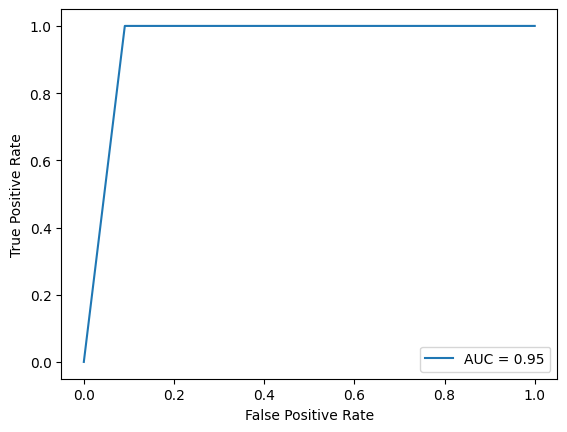

In [18]:
train_decision_tree(X_train, X_test, y_train, y_test)

## Random forest classifier

In [24]:
def train_rand_forest(X_train, X_test, y_train, y_test, num_folds=10):
    
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle= True, random_state= 42)
    params = {'max_depth': np.arange(2, 11),
            'min_samples_leaf': np.arange(2, 11)}
    
    best_rf = GridSearchCV(estimator=model, param_grid=params, cv=skf, n_jobs=-1)
    best_rf.fit(X_train, y_train)
    print(f'Best depth: {best_rf.best_params_["max_depth"]}')
    print(f'Min samples leaf: {best_rf.best_params_["min_samples_leaf"]}\n')
    
    # Cross-validation
    cv_results = cross_val_score(best_rf, X_train, y_train, cv=skf, scoring='accuracy')
    print(f'Cross-Validation Accuracy (Random Forest): {np.mean(cv_results)}')   
    evaluate(best_rf, "Random forest classifier")

Best depth: 7
Min samples leaf: 5

Cross-Validation Accuracy (Random Forest): 0.825
Accuracy: 90.00%
Precision: 0.73
Recall: 1.00
F1 score: 0.84


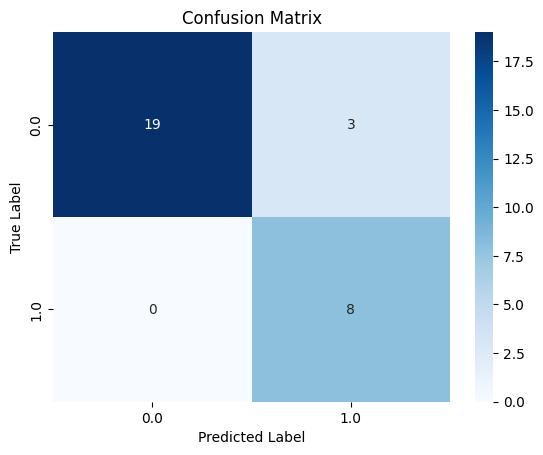

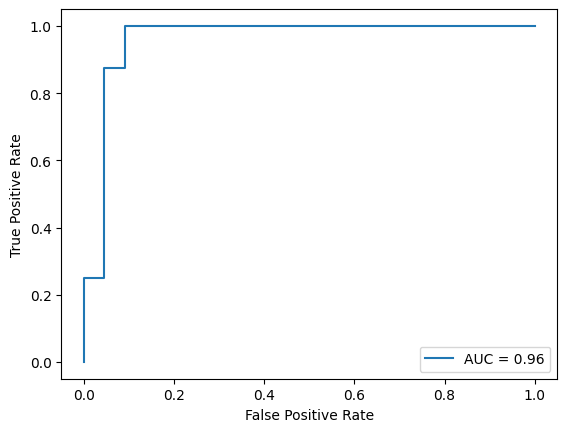

In [25]:
train_rand_forest(X_train, X_test, y_train, y_test)

## SVM classifier

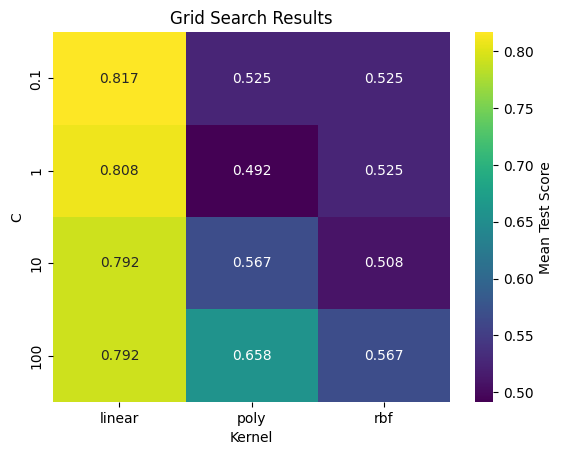

Best C: 0.1
Best kernel: linear


In [32]:
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly']}
grid_search = GridSearchCV(SVC(), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

results = pd.DataFrame(grid_search.cv_results_)

# Visualizing grid search results using a heatmap
heatmap_data = results.pivot(index='param_C', columns='param_kernel', values='mean_test_score')
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.3f', cbar_kws={'label': 'Mean Test Score'})
plt.xlabel('Kernel')
plt.ylabel('C')
plt.title('Grid Search Results')
plt.show()

best_C = best_params['C']
best_kernel = best_params['kernel']
print(f"Best C: {best_C}")
print(f"Best kernel: {best_kernel}")

In [ ]:
def train_svm(X_train, X_test, y_train, y_test, kernel=best_kernel, C=best_C, num_folds=10):
    model = SVC(kernel=kernel, C=C, probability=True).fit(X_train, y_train)
    
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    # Cross-validation
    cv_results = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f'Cross-Validation Accuracy (SVM): {np.mean(cv_results)}')
    
    evaluate(model, "SVM classifier")    

Cross-Validation Accuracy (SVM): 0.8666666666666666
Accuracy: 93.33%
Precision: 0.80
Recall: 1.00
F1 score: 0.89


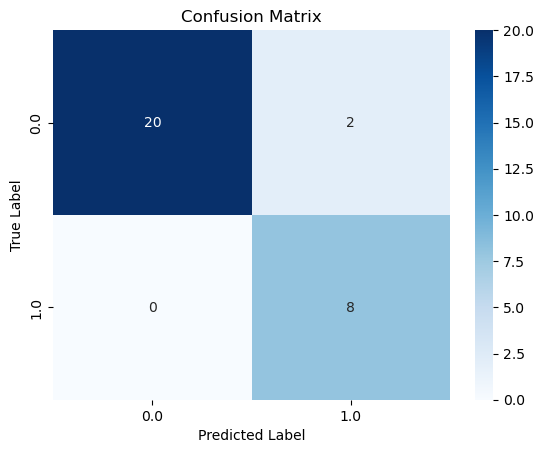

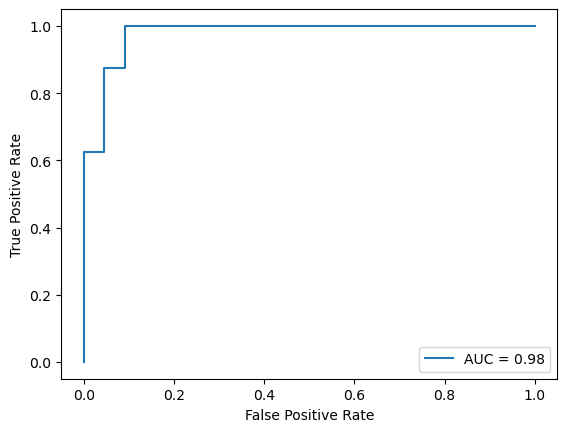

In [ ]:
train_svm(X_train, X_test, y_train.ravel(), y_test)

## XGBoost classifier

In [ ]:
def train_xgboost(X_train, X_test, y_train, y_test, num_folds=10):
    model = XGBClassifier(learning_rate =0.1,
                         n_estimators=100,
                         seed=24).fit(X_train, y_train)
    
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    # Cross-validation
    cv_results = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f'Cross-Validation Accuracy (XGBoost): {np.mean(cv_results)}')
    
    evaluate(model, "XGBoost Classifier")

Cross-Validation Accuracy (XGBoost): 0.8333333333333333
Accuracy: 90.00%
Precision: 0.73
Recall: 1.00
F1 score: 0.84


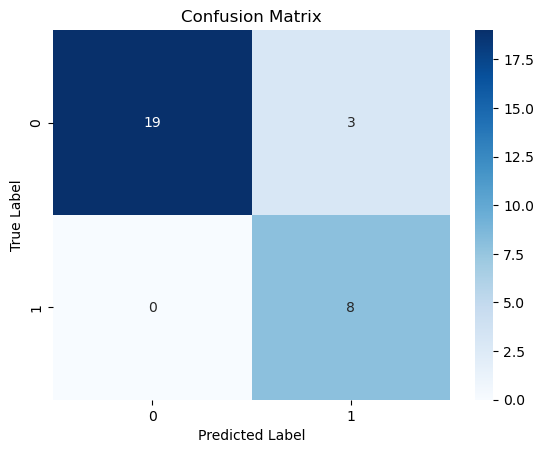

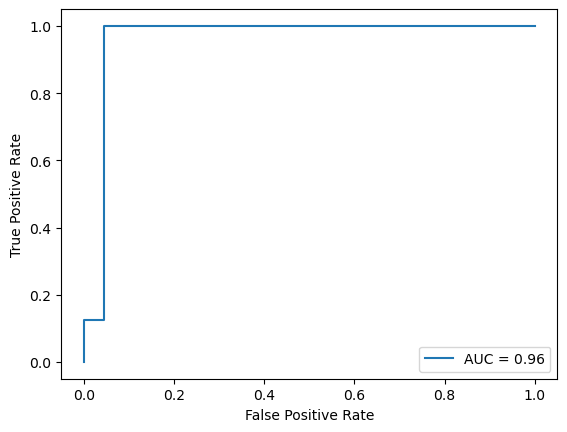

In [ ]:
train_xgboost(X_train, X_test, y_train, y_test)

## Voting classifier

In [ ]:
def train_voting(X_train, X_test, y_train, y_test, num_folds=10):
    df_model = DecisionTreeClassifier()
    rf_model = RandomForestClassifier()
    svm_model = SVC(kernel='linear', probability=True)
    xgb_model = XGBClassifier()

    voting_model = VotingClassifier(estimators=[
        ('df', df_model ),
        ('rf', rf_model),
        ('svm', svm_model),
        ('xgb', xgb_model)
    ], voting='soft').fit(X_train, y_train)
    
    cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    # Cross-validation
    cv_results = cross_val_score(voting_model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f'Cross-Validation Accuracy (Voting): {np.mean(cv_results)}')
    
    evaluate(voting_model, "Voting classifier")

Cross-Validation Accuracy (Voting): 0.8
Accuracy: 90.00%
Precision: 0.73
Recall: 1.00
F1 score: 0.84


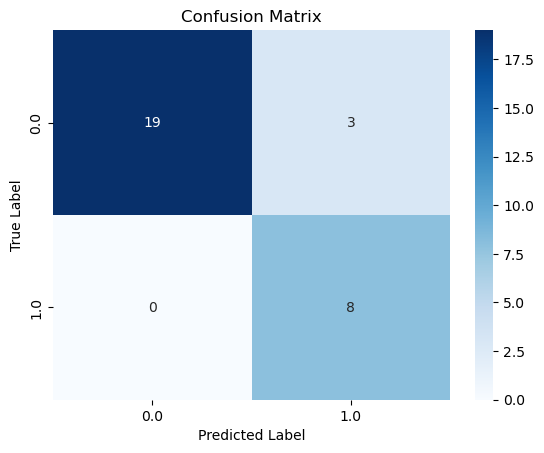

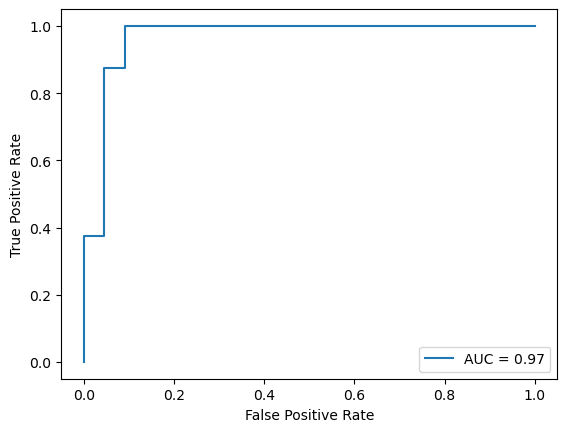

In [ ]:
train_voting(X_train, X_test, y_train, y_test)

## Usporedba performansi svih modela

In [33]:
df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
df_metrics

,Accuracy,Precision,Recall,F1-score
Decision tree classifier,0.866667,0.666667,1.0,0.800000
Random forest classifier,0.900000,0.727273,1.0,0.842105


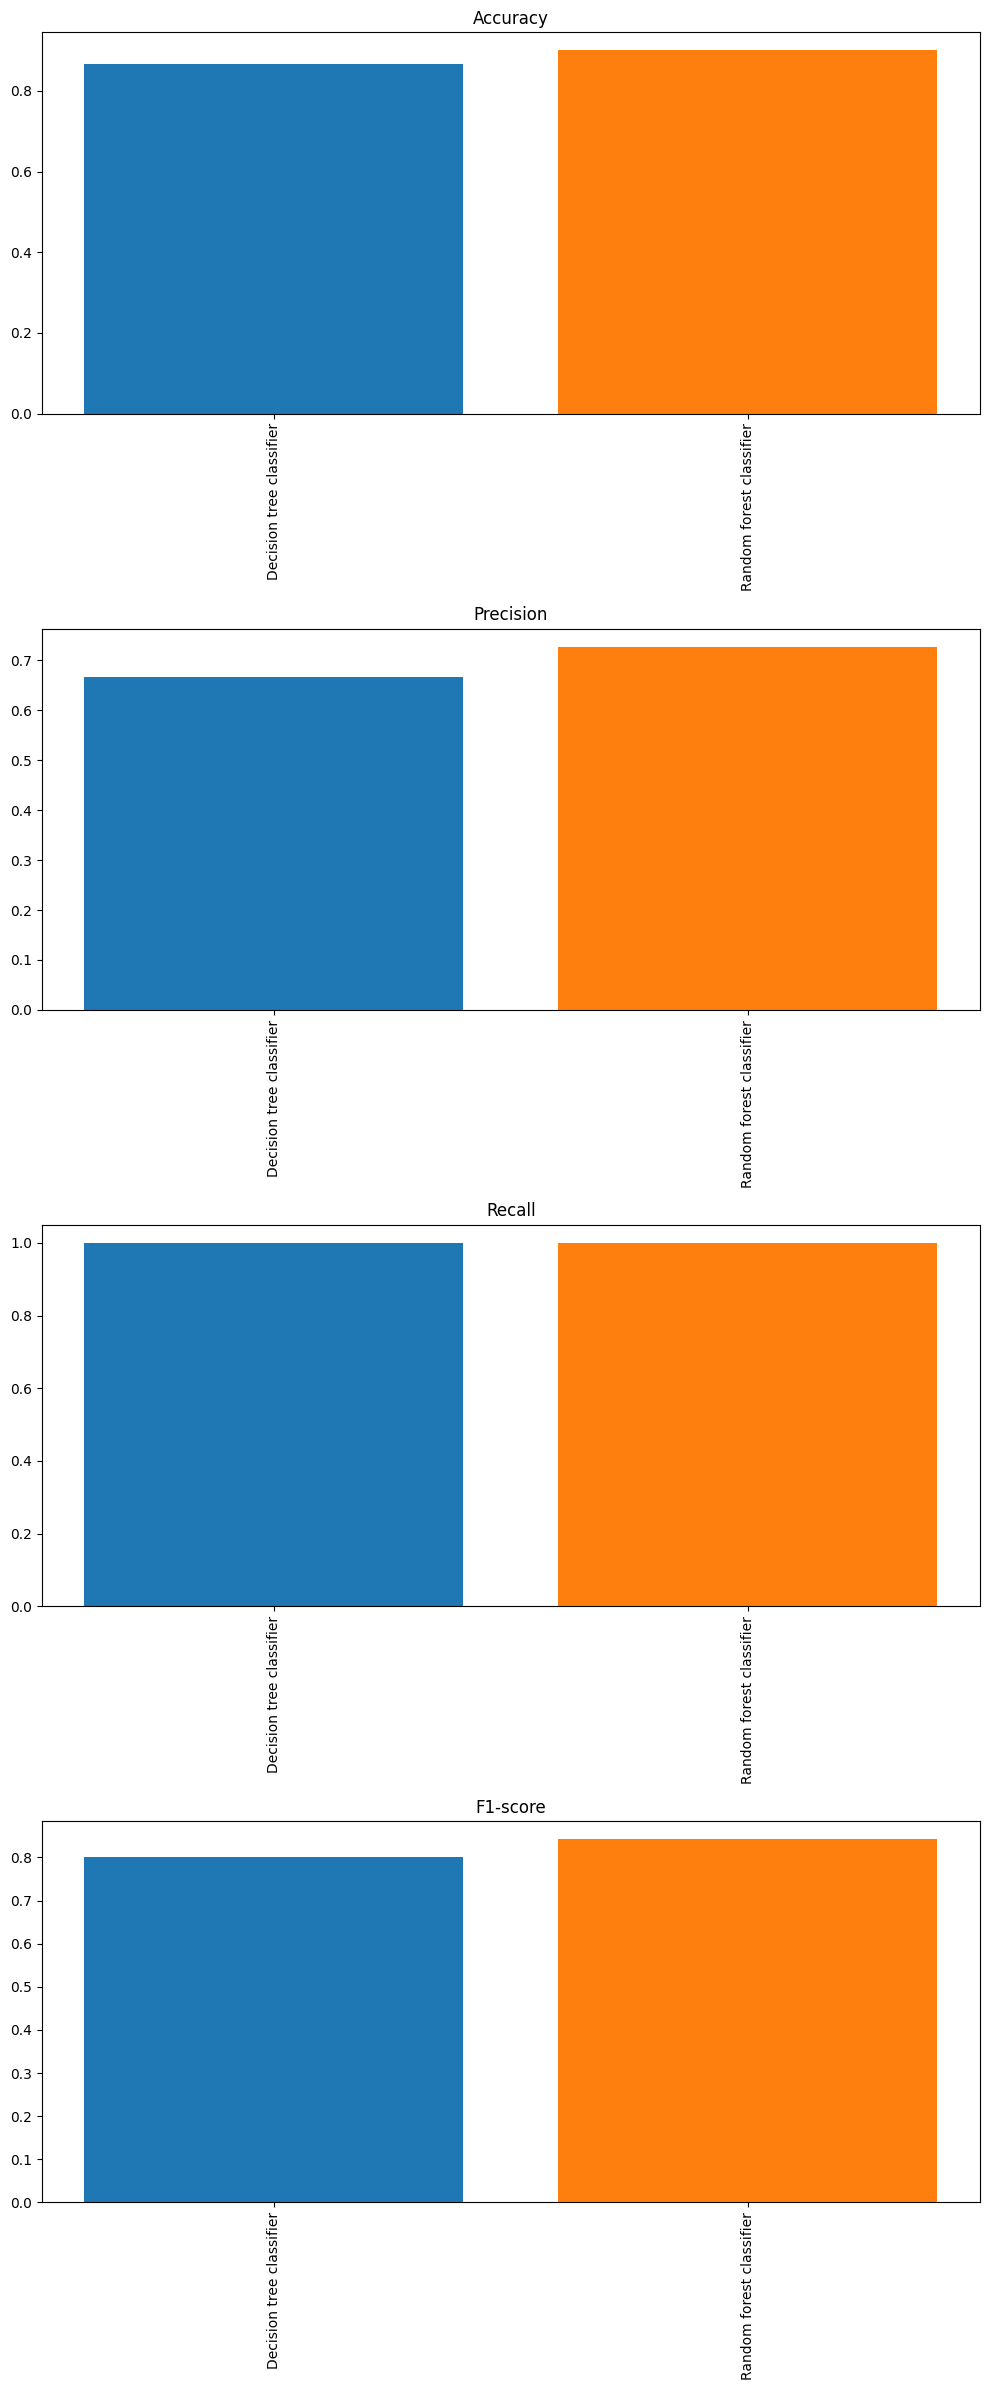

In [34]:
fig, axes = plt.subplots(4, 1, figsize=(10, 24))

for i, metric in enumerate(df_metrics.columns):
    for model_name, metric_value in zip(df_metrics.index, df_metrics[metric]):
        axes[i].bar(model_name, metric_value, label=model_name)
    
    axes[i].set_xticks(range(len(df_metrics.index)))
    axes[i].set_xticklabels(df_metrics.index, rotation=90, ha='center') 
    axes[i].set_title(f'{metric}')

plt.tight_layout()
plt.show()

## Usporedba rezultata

#### Rezultati članka

| Model     | Acurracy | Precision    | Recall   | F1-score |
|-----------|-------------------|--------|---------|----------|
| Decision tree classifier     |      80.46%             |   0.80     |    0.79     |     0.78     |
| Random forest classifier     |         86.92%          |     0.85   |    0.81     |     0.80     |
| Support vector machine     |        81.67%           |    0.77    |    0.70     |    0.79      |
| XGBoost     |         85.92%          |    0.85    |     0.83    |     0.85     | 
| Voting classifier     |      85.12%             |     0.83   |    0.83     |     0.85     |


#### Poboljšani rezultati
| Model                      | Accuracy | Precision | Recall | F1-score |
|-----------------------------|----------|-----------|--------|----------|
| Decision Tree Classifier   | 93.33%   | 0.8000    | 1.0    | 0.8889   |
| Random Forest Classifier   | 90.00%   | 0.7273    | 1.0    | 0.8421   |
| SVM Classifier             | 93.33%   | 0.8000    | 1.0    | 0.8889   |
| XGBoost Classifier         | 86.67%   | 0.6667    | 1.0    | 0.8000   |
| Voting Classifier           | 90.00%   | 0.7273    | 1.0    | 0.8421   |
